# Рынок заведений общественного питания Москвы

Открывается небольшое кафе в Москве, оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Владелец решил обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли он снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

Необходимо подготовить исследование рынка. Имеются открытые данные о заведениях общественного питания в Москве.

## Предобработка данных
Изучим данные из файла, который содержит в себе данные о заведениях общественного питания Москвы

In [1]:
import pandas as pd 
from IPython.display import display
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

df = pd.read_csv('/datasets/rest_data.csv')
df

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36


Проверим таблицу на наличие пропусков и дубликатов, а также выведем основную информацию по ней. Для этого создадим функцию df_info, которую можно будет использовать и в других проектах.

In [2]:
def df_info(df):
    print('Количесвто пропусков:')
    print(df.isnull().sum())
    print('')
    print('Количество дубликатов:')
    print(df.duplicated().sum())
    print('')
    print('информация о таблице:')
    df.info()
    
df_info(df)

Количесвто пропусков:
id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Количество дубликатов:
0

информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Столбец *chain* приведем к булевому типу, чтоб в дальнейшем удобнее было обрабатывать данные.  

In [3]:
df = df.replace({'да': True, 'нет': False})

Для начала приведем названия к нижнему регистру, после чего логичным будет создать таблицу, содержащую в себе информацию о сетях, для того, чтоб создать список уникальных названий сетьевых заведений и интегрировать названия в исходную таблицу

Подобная процедура необходима только для сетевых заведений, ведь с индивидуальными объектами такой проблемы нет. 

In [4]:
df_find_chains = df[df['chain'] == True]
df_find_chains = df_find_chains.rename(columns={'object_name': 'new_name'})
drop_col = ['chain', 'object_type', 
            'address', 'number']
for i in drop_col:
    df_find_chains = df_find_chains.drop(i, 1)
df_find_chains = df_find_chains.reset_index()
df_find_chains['new_name'] = df_find_chains['new_name'].str.lower()
objects_names = ['страбакс', 'теремок', 'мята', 'макдоналдс', 'kfc', 'шоколадница', 'сабвей', 'кофе хаус', 
                 'джонс', 'прайм', "домино'с", 'андерсон', 'вьеткафе', 'иль патио', 'дабл', 'милти']
for i in range(len(df_find_chains)):
    if '«' in df_find_chains['new_name'][i]:
        df_find_chains['new_name'][i] = df_find_chains['new_name'][i].replace('«', '') 
        df_find_chains['new_name'][i] = df_find_chains['new_name'][i].replace('»', '') 
    tmp = df_find_chains['new_name'][i].split()
    for j in range(len(tmp)):
        if tmp[j] in df['object_type'].unique():
            tmp.remove(tmp[j])
            break
    for j in range(len(tmp)):
        if tmp[j] in objects_names:
            df_find_chains['new_name'][i] = tmp[j]
            break
        df_find_chains['new_name'][i] = " ".join(tmp) 
        
df = df.merge(df_find_chains, how='outer')
for i in range(len(df)):
    if df['chain'][i] == True:
        df['object_name'][i] = df['new_name'][i]

drop_col = ['new_name', 'index']
for i in drop_col:
    df = df.drop(i, 1)
df

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,шоколадница,True,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,шоколадница,True,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,шоколадница,True,кафе,"город Москва, поселение Московский, Киевское ш...",36


Данные готовы к анализу

## Анализ данных

### Cоотношение видов объектов общественного питания

Исследуем соотношение видов объектов общественного питания по количеству, а также построим график.

Для начала узнаем уникальные значения столбца *object_type*, чтоб понять какие типы в целом представлены в таблице, после чего найдем долю каждого из них, сгруппировав прежде денные в отдельную таблицу. После чего выведем график. 

Для вычислений создадим функцию, которую можно будет использовать в дальнейшем.

In [5]:
df['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

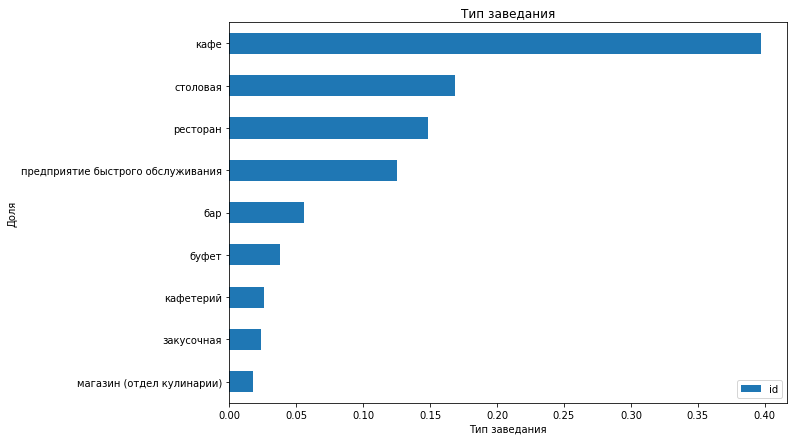

In [6]:
df_types = df.groupby('object_type')['id'].count()

def count_part(df_new, name, typ):
    df_new = df_new.reset_index()
    df_new['id'] = df_new['id'] / df.shape[0]
    df_new = df_new.set_index(name)
    df_new = df_new.sort_values(by='id')

    df_new.plot(y='id', kind='barh', figsize=(10,7))
    plt.title(typ)
    plt.xlabel(typ)
    plt.ylabel('Доля')
    plt.show()
    
count_part(df_types, 'object_type', 'Тип заведания')

Топ 3 типов заведений: 
- ресторан
- столовая
- кафе

Стоит заметить, что кафе - наиболее популярный тип и занимает 40% рынка, при этом столова и ресторан всего 15-17% каждый

### Соотношение сетевых и не сетевых заведений

Исследуем соотношение сетевых и не сетевых заведений по количеству и на основе полученных расчетов построим график.

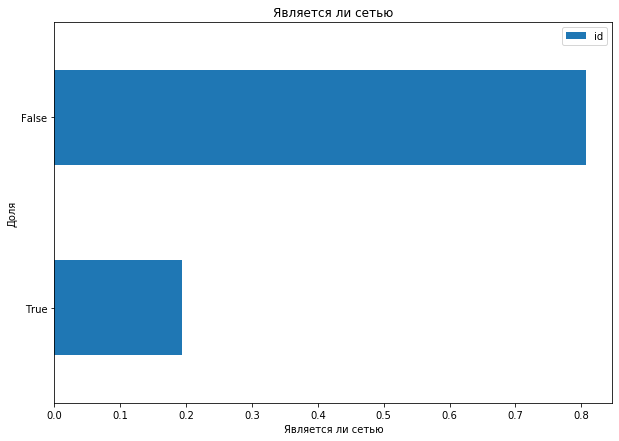

In [7]:
df_chains = df.groupby('chain')['id'].count()

count_part(df_chains, 'chain', 'Является ли сетью')

Гуляя по Москве, может показаться, что все рестораны и кафе вокруг сетевые, но, как выяснилось, они занимают всего лишь 20%, остальное приходится на уникальные завдения.

### Поиск вида объекта общественного питания, для которого характерно сетевое распространение

Найдем вид заведения, для которого сеть наиболее характерна, для этого сгрупируем объекты по виду и посчитаем количесвто сетевых среди них.

In [8]:
df_chain_type = df.pivot_table(columns='object_type', values='chain', aggfunc='mean')
for i in df_chain_type.columns:
    df_chain_type[i][0] = round(df_chain_type[i][0], 3)
df_chain_type

object_type,бар,буфет,закусочная,кафе,кафетерий,магазин (отдел кулинарии),предприятие быстрого обслуживания,ресторан,столовая
chain,0.043,0.019,0.156,0.229,0.131,0.286,0.411,0.238,0.001


Предприятие быстрого обслуживания являеется наиболее частым представителем сетевого распространения, после чего идет магазин (отдел кулинарии). 

### Изучение сетей

Что характерно для сетевых заведений: много объектов с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест? 

Для того, чтоб это узнать, для начала выясним, что значит много: посмотрим сколько заведений входят в каждую из сетей и сколько у них в среднем посадочных мест.

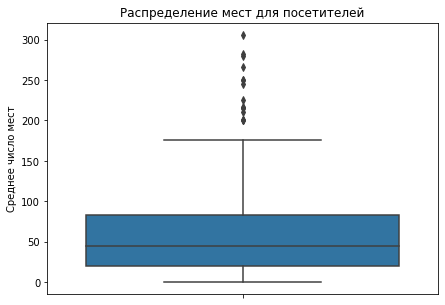

In [9]:
df_chains_info = df[df['chain'] == True]

df_ch = (
    df_chains_info.groupby('object_name')
    .agg({'number': 'mean', 'id':'count'})
    .reset_index()
)

plt.figure(
    figsize=(7, 5)
)
sns.boxplot(y='number', data=df_ch) 
plt.title('Распределение мест для посетителей')
plt.ylabel('Среднее число мест')
plt.show()

В среднем в завадениях около 50 мест, однако встречаются места, где их сильно больше 200. Тогда будем счатать, что все что больше 80 - много посадочных мест. 

Посмотрим теперь на количесвто заведений в сетях.

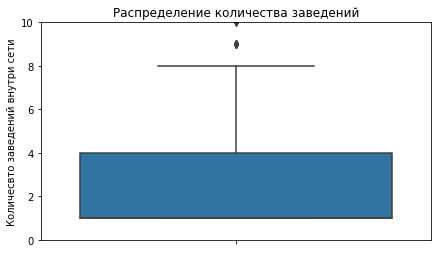

In [10]:
plt.figure(
    figsize=(7, 4)
)
sns.boxplot(y='id', data=df_ch)
plt.title('Распределение количества заведений')
plt.ylabel('Количесвто заведений внутри сети')
ax = plt.gca()
ax.set_ylim([0,10])
plt.show()

В целом внутри сетей самих заведений довольно не много: обычно это число не превышает 4, будем считать что много заведений - когда их больше четырех. 

Создадим функцию, которая будет присваивать тип каждому заведению с учетом следующих групп:
- Сеть с большим числом посадочных мест и небольшим числом заведений в сети
- Сеть с небольшим числом посадочных мест и большим числом заведений в сети
- Сеть с небольшим числом посадочных мест и небольшим числом заведений в сети
- Сеть с большим числом посадочных мест и большим числом заведений в сети

С учетом этих распределений и определим наиболее характерные признаки. 

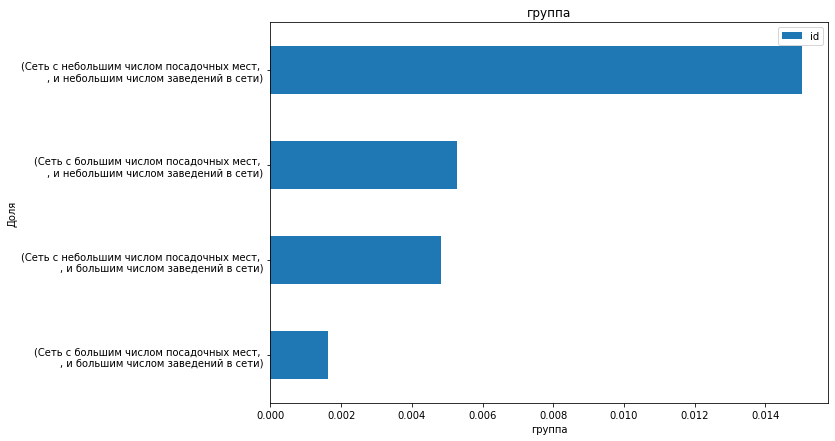

In [11]:
def find_group(row) :  
    seats = row['number']
    cnt = row['id']
    
    if seats > 80:
        if cnt > 4:
            return 'Сеть с большим числом посадочных мест', '\n', 'и большим числом заведений в сети'
        else:
            return 'Сеть с большим числом посадочных мест', '\n', 'и небольшим числом заведений в сети'
        
    else : 
        if cnt > 4:
            return 'Сеть с небольшим числом посадочных мест', '\n', 'и большим числом заведений в сети'
        else:
            return 'Сеть с небольшим числом посадочных мест', '\n', 'и небольшим числом заведений в сети'
df_ch['group'] = df_ch.apply(find_group, axis=1) 

res = df_ch.groupby('group')['id'].count()
count_part(res, 'group', 'группа')

По получившимся графикам можно сделать вывод: характернее всего для стевых заведений - небольшое число как самих мест, так и ресторанов.

### Среднее количество посадочных мест для каждого типа заведения

Определим сколько в среднем посадочных мест в разных типах заведений, а также сравним эти значения и изобразим это на графике. 

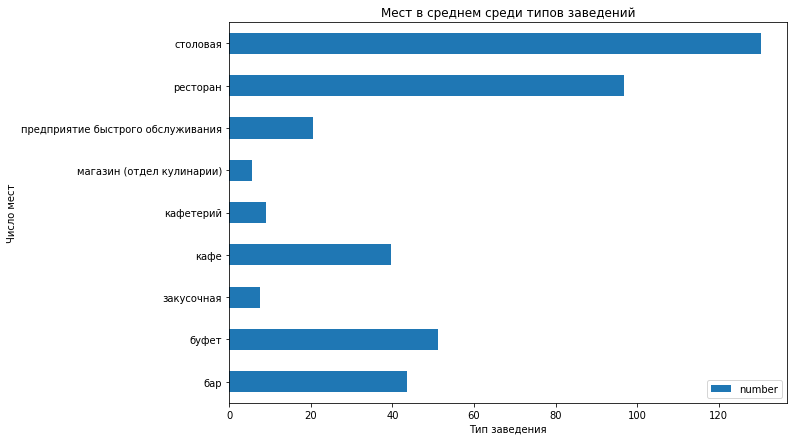

In [12]:
df_places_mean = df.groupby('object_type')['number'].mean()
df_places_mean = df_places_mean.reset_index()
df_places_mean = df_places_mean.set_index('object_type')

df_places_mean.plot(y='number', kind='barh', figsize=(10,7))
plt.title('Мест в среднем среди типов заведений')
plt.xlabel('Тип заведения')
plt.ylabel('Число мест')
plt.show()

Двумя несомненными лидерами являются столовая и ресторан, которые в среднем имеют наибольшее число посадочных мест. 

### Информация об улице 

Выведем в отдельный столбец информацию об улице из столбца *address*

Так как у нас адрес строится следующим образом: город, улица, дом, то если поместить это в массив, на месте с индексом 1 будет улица. Применим это для заведений:

In [13]:
df['streetname'] = 0
for i in range(len(df)):
    tmp = df['address'][i].split(",")
    if ('город' not in tmp[1]) and ('поселение' not in tmp[1]):
        df['streetname'][i] = tmp[1]
    else:
        df['streetname'][i] = tmp[1] + tmp[2]
    a = df['streetname'][i]
    a = a[1:]
    df['streetname'][i] = a

**Коментарий для проверяющего:** проверяются только город и поселения, потому что именно они портят топ, все остальное не входит в рассматриваемые сегменты. 

### Поиск улицы с наибольшим числом заведений на ней

Подгрузим таблицу с координатами районов и найдем районы с наибольшей плотностью. 

In [14]:
df_address = pd.read_csv('mosgaz-streets.csv')
drop_col_address = ['areaid', 'okrug']
for i in drop_col_address:
    df_address = df_address.drop(i, 1)
df_address

,streetname,area
0,Выставочный переулок,Пресненский район
1,улица Гашека,Пресненский район
2,Большая Никитская улица,Пресненский район
3,Глубокий переулок,Пресненский район
4,Большой Гнездниковский переулок,Пресненский район
...,...,...
4393,Вознесенский проезд,Пресненский район
4394,Волков переулок,Пресненский район
4395,Поварская улица,Пресненский район
4396,Кудринская площадь,Пресненский район


Добавим информацию о районах в основную таблицу и немного преобразуем содержимое ячеек для удобного использования в дальнейшем:

In [15]:
df['area'] = ''
street_list = list(df_address['streetname'])
for i in range(len(df)):
    if df['streetname'][i] in street_list:
        tmp = street_list.index(df['streetname'][i])
        df['area'][i] = df_address['area'][tmp] + ' '
        street_list.remove(df['streetname'][i])
        if df['streetname'][i] not in street_list:
            street_list.insert(tmp, df['streetname'][i])

Сгруппируем улицы по количеству заведений на ней, а также выведем график для ТОП-10 самый наполненых ресторанами, после чего выведем таблицу с информацией в каких районах располагаются данные улицы. 

In [16]:
df_street_cnt = (
    df.groupby('streetname')
    .agg({'id':'count', 'number': 'mean', 'area': 'sum'})
    .reset_index()
)
for i in range(len(df_street_cnt)):
    tmp = df_street_cnt['area'][i].split()
    d = []
    for j in range(len(tmp)):
        if tmp[j] in d:
            continue
        else:
            d.append(tmp[j])
    df_street_cnt['area'][i] = ' '.join(d)

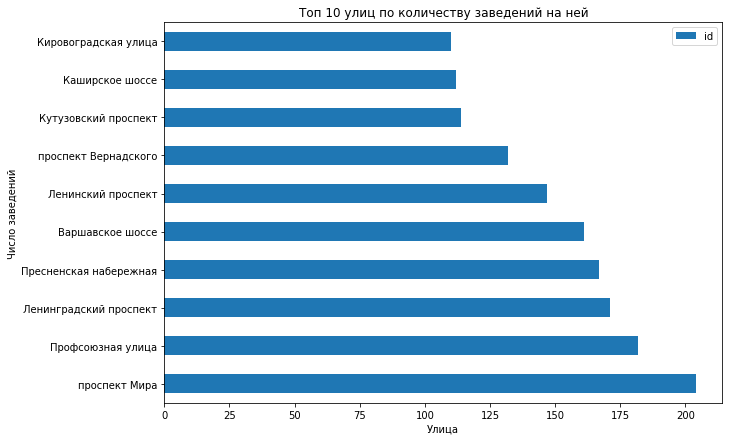

,streetname,area
0,проспект Мира,Войковский Район Алтуфьевский район Лианозово Марфино Марьина роща Отрадное Якиманка Южное Бутово Коньково Ясенево Гагаринский Хамовники Черемушки Академический
1,Профсоюзная улица,Нижегородский район Район Печатники Рязанский Текстильщики Выхино-Жулебино Академический Люблино Лефортово Хамовники
2,Ленинградский проспект,Панфиловский район Район Аэропорт Дмитровский Савеловский Хорошевский Головинский Бескудниковский Беговой Басманный
3,Пресненская набережная,Пресненский район
4,Варшавское шоссе,Район Царицыно Даниловский район Донской Нагатино-Садовники Рязанский Выхино-Жулебино Нижегородский Марьино Люблино Хамовники
5,Ленинский проспект,Район Очаково-Матвеевское Басманный район Даниловский Текстильщики Черемушки Гагаринский Зюзино Ясенево Хамовники Академический Выхино-Жулебино Рязанский Печатники Нижегородский
6,проспект Вернадского,Район Очаково-Матвеевское Проспект Вернадского Солнцево Академический район Ясенево Хамовники Печатники Нижегородский Некрасовка Марьино Лефортово
7,Кутузовский проспект,Район Дорогомилово Филевский Парк Сокольники Басманный район
8,Каширское шоссе,Даниловский район Район Москворечье-Сабурово Нагатино-Садовники Братеево Бирюлево Западное Восточное Южное Тушино
9,Кировоградская улица,Район Бирюлево Западное Братеево Щукино Митино Хамовники Куркино


In [17]:
df_street_cnt = df_street_cnt.sort_values(by='id', ascending=False)
df_street_cnt_10 = df_street_cnt.head(10)
df_street_cnt_10 = df_street_cnt_10.set_index('streetname')

df_street_cnt_10.plot(y='id', kind='barh', figsize=(10,7))
plt.title('Топ 10 улиц по количеству заведений на ней')
plt.xlabel('Улица')
plt.ylabel('Число заведений')
plt.show()

df_street_cnt_10 = df_street_cnt_10.reset_index()
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200
df_street_cnt_10[['streetname', 'area']]

Как выяснилось: представленные улицы очень длинные, они простираются на территории сразу нескольких раонов, поэтому и заведений на них больше. Улицы почти не пересекаются между собой, однако иногда все же встречаются районы, на территории которых находятся сразу несколько улиц из топа. 

Визуализируем распределение на улицах из ТОП-10 на карте

Прежде всего скачаем необходимые библиотеки:

In [18]:
!pip install geopy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 118 kB 2.8 MB/s eta 0:00:01


In [19]:
pip install folium

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 95 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Создадим таблицу, содержащую информацию о заведениях, расположенных на улицах из топа

In [20]:
df_top10_info = pd.DataFrame(columns=['address','streetname', 'number'])

for j in df_top10_info.columns:
    tmp_list = []
    for i in range(len(df)):
        if df['streetname'][i] in list(df_street_cnt_10['streetname']):
            tmp_list.append(df[j][i])
    df_top10_info[j] = tmp_list
df_top10_info

,address,streetname,number
0,"город Москва, Варшавское шоссе, дом 2",Варшавское шоссе,150
1,"город Москва, Варшавское шоссе, дом 7, корпус 1",Варшавское шоссе,36
2,"город Москва, Варшавское шоссе, дом 29",Варшавское шоссе,30
3,"город Москва, Варшавское шоссе, дом 72, корпус 2",Варшавское шоссе,0
4,"город Москва, Варшавское шоссе, дом 100",Варшавское шоссе,2
...,...,...,...
1495,"город Москва, Пресненская набережная, дом 12",Пресненская набережная,25
1496,"город Москва, Ленинградский проспект, дом 80, корпус 17",Ленинградский проспект,0
1497,"город Москва, Профсоюзная улица, дом 142, корпус 1, строение 1",Профсоюзная улица,40
1498,"город Москва, Каширское шоссе, дом 96, корпус 1",Каширское шоссе,35


Определим координаты:

In [21]:
from geopy.geocoders import Nominatim
from functools import partial
import time
from geopy.exc import GeocoderTimedOut

def do_geocode(address):
    try:
        return geocode(address).raw
    except GeocoderTimedOut:
        return do_geocode(address)

geolocator = Nominatim(user_agent="my_fancy_application")


geocode = partial(geolocator.geocode, language="ru")
reverse = partial(geolocator.reverse, language="ru")

dict_geo = {}
df_top10_info['lat'] = 0
df_top10_info['lon'] = 0

#for i in range(len(df_top10_info)):
#    try:
#        dict_geo = do_geocode(df_top10_info['address'][i])
#        df_top10_info['lat'] = dict_geo['lat']
#        df_top10_info['lon'] = dict_geo['lon']
#    except AttributeError:
#        df_top10_info['lat'] = 0
#        df_top10_info['lon'] = 0
#print(df_top10_info.head(10))

Теперь визуализируем полученные координаты на карте:

In [22]:
import folium
m = folium.Map(location=[55.558741,  37.378847], zoom_start=12, tiles="Stamen Terrain")

tooltip = "Click me!"

#for i in range(len(df_top10_info)):
#    folium.Marker(
#        [df_top10_info['lat'][i], df_top10_info['lon'][i]], popup="<i>Mt. Hood Meadows</i>", tooltip=tooltip
#    ).add_to(m)


#m

### Число улиц с одним объектом общественного питания

Посмотрим теперь на каких улицах всего одно заведение:

In [23]:
df_street_cnt_1 = df_street_cnt[df_street_cnt['id'] == 1]
len(df_street_cnt_1)

766

Как оказалось таких улиц 766, среди которых как улицы с короткой протяженностью, расположенные в Москве, так и те заведения, которые находятся в московской области.

Сгруппируем по району и посмотрим, в каких количество таких улиц наибольшее

In [24]:
grouped_street1 = df_street_cnt_1.groupby('area')['streetname'].count().reset_index().sort_values(by='streetname', ascending=False)
grouped_street1['area'][0] = 'Московская область'
grouped_street1.head(10)

,area,streetname
0,Московская область,250
103,Тверской район,29
102,Таганский район,25
19,Пресненский район,22
87,Район Хамовники,21
5,Басманный район,21
20,Район Арбат,15
37,Район Замоскворечье,13
85,Район Филевский Парк,10
61,Район Ново-Переделкино,10


Несомненным лидером является Московская область, после чего следуют районы, расположенные в инсторическом центре, который несомненно содежит большое количество маленьких улочек. 

### Число мест на улицах с наибоьшим числом заведений

Выявим закономерности распределения заведений на загружанных улицах: посмотрим сколько посадочных мест на этих улицах в среднем и сравним это значение с тем, что присуще остальным заведениям по Москве, построив новый график *boxplot*

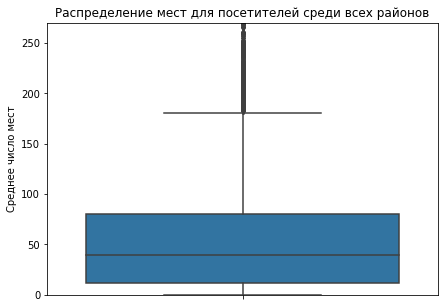

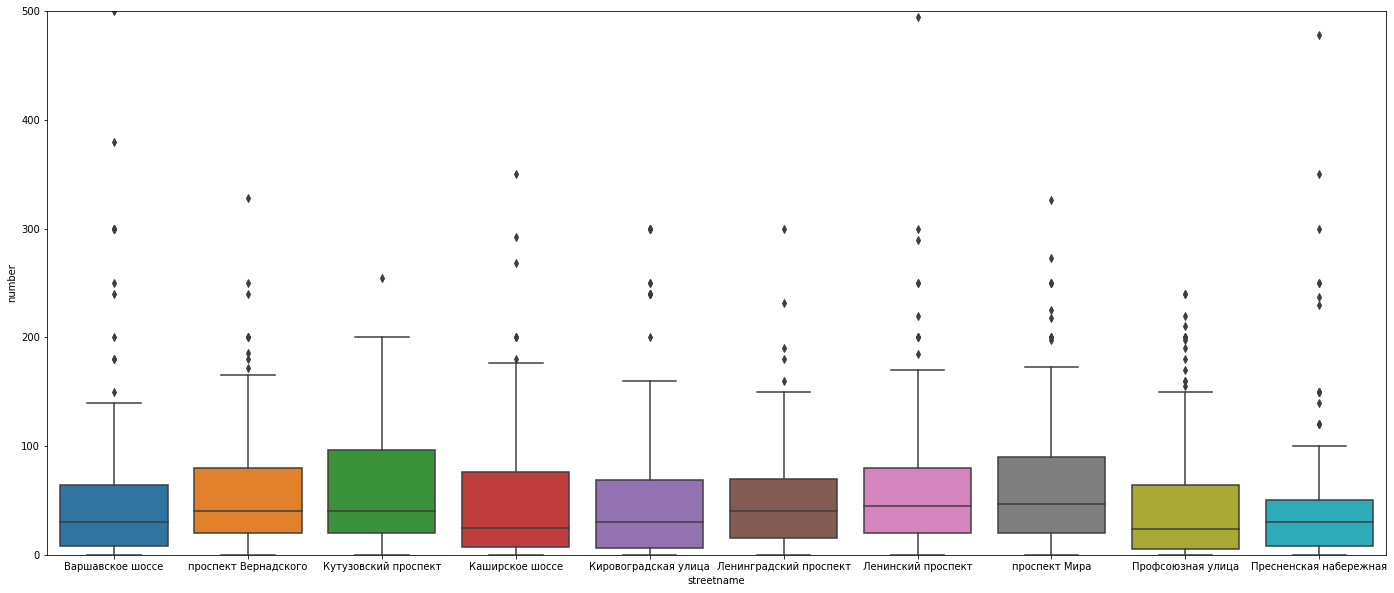

In [27]:
plt.figure(
    figsize=(7, 5)
)
sns.boxplot(y='number', data=df) 
plt.title('Распределение мест для посетителей среди всех районов')
plt.ylabel('Среднее число мест')
ax = plt.gca()
ax.set_ylim([0,270])
plt.show()

plt.figure(figsize=(24,10))
sns.boxplot(data=df[df['streetname'].isin(df_top10_info['streetname'])], x='streetname',y='number')
plt.ylim((0,500))
plt.show()

Итак, в среднем мест в заведениях чуть меньше 50, на представленных же улицах мест немного больше, скорее всего это связанно с высокой проходимостью, а также большим потоком посетителей. 

**Выводы:**

На основе анализа сформировались следующие выводы: наиболее распространенный тип заведения - кафе, он ориентирован на большую аудиторию, а это значит, что он будет притягивать большее число посетителей; как показал график о количестве мест, наиболее приемлемым числом является 40-50 для районов со средней загруженностью и более 50 для улиц с большим количесвтом заведений, это значит, что именно от выбранной локации зависит конечное число посадочных мест; благоприятными будут те районы, которые имеют наибольшую проходимость, так как там поток клиентов выше. 

Рекомендуется все же начать с одного кафе, объект поместить ближе к центру на одну улицу из топа, количество мест тем самым сделать по возможности 50-60.

**Презентация:**

https://disk.yandex.ru/d/vU2WZ8QUE4Vjew